# Import Packages

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# try:
#     import pyadts
# except:
#     !pip install pyadts

In [3]:
import sys
sys.path.append('..')

In [4]:
from pyadts.data.repository import get_kpi

# Prepare Data & Pre-processing

In [5]:
data_df, meta_df = get_kpi(root_path='../tests/data/kpi', kpi_id=0)
data_df.head()

,value
timestamp,
2017-04-01 18:08:00,35.03
2017-04-01 18:09:00,36.60
2017-04-01 18:10:00,32.79
2017-04-01 18:11:00,34.28
2017-04-01 18:12:00,34.69


In [6]:
from pyadts.data.preprocessing import series_rearrange
from pyadts.data.preprocessing import series_impute
from pyadts.data.preprocessing import series_normalize

In [7]:
data_df, meta_df = series_rearrange(data_df, meta_df)

[INFO] Before processing, the shape of data: (295385, 1).
[INFO] Detected minimum interval: 0 days 00:01:00.
[INFO] After processing, the shape of data: (295385, 1).


In [8]:
from pyadts.utils.visualization import plot_series

<ipython-input-9-52caadc0f650>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


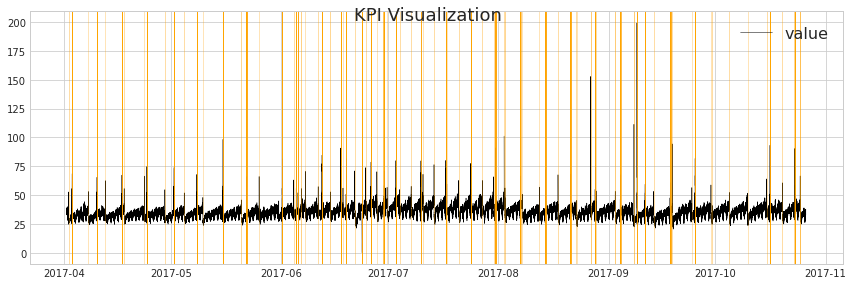

In [9]:
%matplotlib inline
fig = plot_series(data_df, meta_df, title='KPI Visualization')
fig.show()


In [10]:
series_impute(data_df, method='linear')
series_normalize(data_df, method='zscore')

<ipython-input-11-89f652a3b477>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


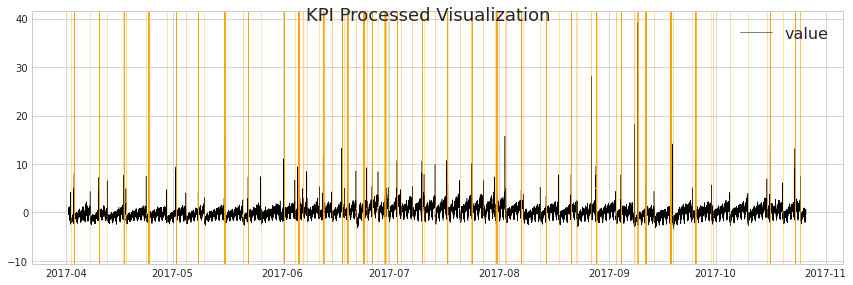

In [11]:
fig = plot_series(data_df, meta_df, title='KPI Processed Visualization')
fig.show()

# Feature Extraction

In [12]:
from pyadts.data.feature import get_all_features

In [13]:
features = get_all_features(data_df, get_stl=False, window_list=[50, 100, 200])

[INFO] Processing spectral residual feature...
[INFO] Processing simple features...
[INFO] Processing SARIMA features...


..\pyadts\data\feature\__simple_features.py:5: RuntimeWarning: invalid value encountered in log
  return np.log(value)


[INFO] Processing ExponentialSmoothing features...


D:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


[INFO] Processing Holt features...
[INFO] Processing SimpleExpSmoothing features...


SLIDING_WINDOW:   0%|▏                                                          | 640/298953 [00:00<00:46, 6399.90it/s]

[INFO] Processing wavelet features...
[INFO] Processing window features...


SLIDING_WINDOW: 100%|████████████████████████████████████████████████████████| 298653/298653 [00:31<00:00, 9545.94it/s]


In [14]:
features.shape

(298653, 54)

In [15]:
meta_df = meta_df.iloc[-features.shape[0]:, :]

In [16]:
from pyadts.data.utils import train_test_split

In [17]:
train_x, train_y, test_x, test_y = train_test_split(features, meta_df, train_ratio=0.5)

In [18]:
from pyadts.evaluation.metrics import roc_auc, pr_auc, best_f1, best_precision, best_recall

# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
# rf = RandomForestClassifier()

In [21]:
# rf.fit(train_x, train_y)

In [22]:
# scores = rf.predict_proba(test_x)

# XGBoost

In [23]:
import xgboost as xgb

In [24]:
train_matrix = xgb.DMatrix(train_x, label=train_y['label'])

In [25]:
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2

In [26]:
bst = xgb.train(param, train_matrix, num_round)

In [27]:
test_matrix = xgb.DMatrix(test_x)

In [28]:
scores = bst.predict(test_matrix)

In [29]:
scores.shape

(149327,)

In [30]:
test_y.shape

(149327, 2)

In [40]:
roc = roc_auc(scores, test_y['label'].values, delay=7)
print(roc)
print(pr_auc(scores, test_y['label'].values, delay=7))

0.9967637901941548
0.9356619197960295


In [41]:
print(best_f1(scores, test_y['label'].values, delay=7))

0.9560878243512975


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function best_f1 is deprecated; Using F1-score to evaluate anomaly detection algorithms is not recommended.
  warnings.warn(msg, category=FutureWarning)


In [33]:
from pyadts.utils.visualization import plot_roc

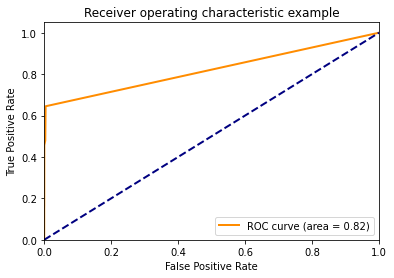

In [34]:
plot_roc(scores, test_y['label'].values)

In [35]:
predictions = np.zeros_like(scores).astype(np.int)
predictions[scores>0.5] = 1

In [36]:
pd.DataFrame(predictions).shape

(149327, 1)

In [37]:
data_df.iloc[-predictions.shape[0]:,:].shape

(149327, 1)

<ipython-input-38-d8b9e0c33124>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


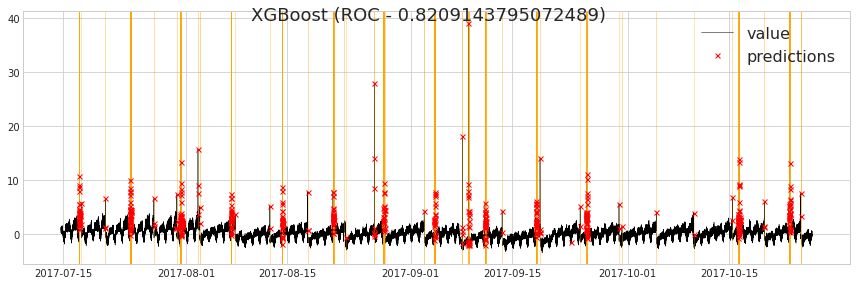

In [38]:
fig = plot_series(data_df.iloc[-predictions.shape[0]:,:], test_y, predictions=pd.DataFrame(predictions), title=f'XGBoost (ROC - {roc})')
fig.show()